# DM Estimation Linéaire 2

## Introduction

### Chargement des mesures

In [2]:
import numpy as np 

z = np.array([ [-10.171],
               [-8.314],
               [-6.452],
               [-4.175],
               [-1.996],
               [0.179],
               [2.816],
               [4.170],
               [6.734],
               [7.356],
               [10.894],
               [12.254] ])

y = np.array([ [350.826],
               [218.434],
               [146.850],
               [71.788],
               [23.079],
               [14.813],
               [50.694],
               [95.434],
               [185.819],
               [265.981],
               [403.319],
               [579.559] ])

sigma_z = 0.4
sigma_y = 0.6


### Aperçu des mesures

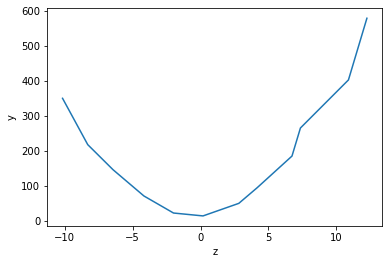

In [3]:
import matplotlib.pyplot as plt 

fig = plt.figure()
plt.plot(z,y)
plt.xlabel('z')
plt.ylabel('y')
plt.show()

### Modèle Stochastique

In [4]:
# Mise en place vecteur l
l = np.zeros((24,1))
for i in range(12):
    l[[j for j in range(0,24,2)][i]] = y[i]
    l[[j for j in range(0,24,2)][i]+1] = z[i]

# Matrice de variance-covariance
Kl = np.identity(24)
for i in range(24):
    if i%2 == 0:
        Kl[i,i] = sigma_y**2
    else:
        Kl[i,i] = sigma_z**2

sigma0 = 0.2

# Matrice des cofacteurs
Ql = 1/sigma0**2 * Kl

## Polynôme de degré 2

### Initialisation

In [5]:
def f(x,l):
    result = np.zeros((12,1))
    even_list = [i for i in range(0,24,2)]
    for i in range(12):
        result[i] = x[0] + x[1]*l[even_list[i]+1] + x[2]*l[even_list[i]+1]**2 - l[even_list[i]]
    return result

x0 = np.array([[1],[1],[1]])

w = f(x0,l)

# Building A
def gen_A(l):
    z = l[1:24:2]
    return np.hstack( ( np.ones((12,1)), z, z**2 ) )
A = gen_A(l)

# Building G
def gen_G(l,x):
    z = l[1:24:2]
    G = np.zeros((12,24))
    for i in range(0,12):
        G[i,[i for i in range(0,24,2)][i]] = -1
        G[i,[i for i in range(0,24,2)][i]+1] = x[1] + 2*x[2]*z[i]
    return G
G = gen_G(l,x0)

### Dimensions

In [6]:
n = l.shape[0]
p = x0.shape[0]
r = A.shape[0]
print('n',n)
print('p',p)
print('r',r)

n 24
p 3
r 12


### Matrice de calcul

In [7]:
# Raccourci pour calcul matrice inverse
I = lambda M : np.linalg.inv(M)

S = Ql @ G.T @ I(G @ Ql @ G.T)

### Paramètres et leurs cofacteurs

In [8]:
dx_ = - I(A.T @ I(G @ Ql @ G.T) @ A) @ A.T @ I(G @ Ql @ G.T) @ w
x_ = x0 + dx_

# Iterations
for k in range(5):
    A = gen_A(l)
    G = gen_G(l,x_)
    S = Ql @ G.T @ I(G @ Ql @ G.T)
    dx_ = - I(A.T @ I(G @ Ql @ G.T) @ A) @ A.T @ I(G @ Ql @ G.T) @ w
    x_ = x0 + dx_

Qx_ = I(A.T @ I(G @ Ql @ G.T) @ A)

print('dx_\n',dx_)
print('x_\n',x_)
print('Qx_\n',Qx_)

dx_
 [[13.66362562]
 [ 1.78790887]
 [ 2.48593173]]
x_
 [[14.66362562]
 [ 2.78790887]
 [ 3.48593173]]
Qx_
 [[62.45146243  1.08292959 -1.15011618]
 [ 1.08292959 17.09993958 -0.13482998]
 [-1.15011618 -0.13482998  0.33375797]]


### Observations compensées et leurs cofacteurs

In [9]:
v_ = S @ (A @ dx_ + w)
l_ = l - v_
Qv_ = S @ G @ Ql - S @ A @Qx_ @ A.T @ S.T
Ql_ = Ql - Qv_

### Erreur moyenne quadratique

In [12]:
sigma0_2 = v_.T @ I(Ql) @ v_ / (r-p)
print(float(sigma0_2/sigma0**2))
print(float(sigma0_2/sigma0**2) < 2)

0.2 [[0.19586657]]
0.9590928280858514
True


### Aperçu du résultat

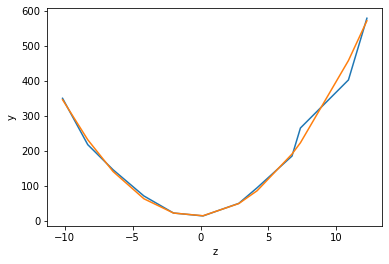

In [11]:
pol_d2 = lambda x,z : x[0] + x[1]*z + x[2]*z**2

fig_res = plt.figure()
plt.plot(z,y)
plt.plot(z,pol_d2(x_,z))
plt.xlabel('z')
plt.ylabel('y')
plt.show()